# Complex Newtowrks final project

---

In [909]:
import numpy as np
import matplotlib.pyplot as plt
import nilearn 
from nilearn import datasets
from nilearn import connectome
import nibabel as nib
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import seaborn as sns
from tqdm.notebook import tqdm
import multinetx as mx

%matplotlib inline
sns.set()

In [910]:
autism_data = datasets.fetch_abide_pcp(data_dir="/Users/abelrassat/Desktop/NSC/Complex_Networks_Theory_and_Application/Project/Autism_Data/", band_pass_filtering=True, legacy_format=False, pipeline='cpac', DX_GROUP=1)

In [911]:
control_data = datasets.fetch_abide_pcp(data_dir="/Users/abelrassat/Desktop/NSC/Complex_Networks_Theory_and_Application/Project/Control_Data/", n_subjects=30, band_pass_filtering=True, legacy_format=False, pipeline='cpac', DX_GROUP=2)

In [912]:
print(type(autism_data))
attributes = dir(autism_data)
print(attributes)
print(len(autism_data.func_preproc))
print(len(control_data.func_preproc))
#print(autism_.description)

<class 'sklearn.utils._bunch.Bunch'>
['description', 'func_preproc', 'phenotypic']
403
30


In [913]:
# testing on a subset of the data 30 subjects in each group
autism_data.func_preproc = autism_data.func_preproc[:30]
control_data.func_preproc = control_data.func_preproc[:30]

---

## 1. Data extraction

### 1.1 Autism Data

In [259]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas["maps"]
labels = atlas["labels"]
num_ROIs = len(labels)

# Create a masker to extract time series
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize="zscore_sample")
correlation_measure = ConnectivityMeasure(kind="correlation", standardize="zscore_sample")

pop_correlation_matrices = np.zeros((len(autism_data.func_preproc), num_ROIs, num_ROIs))

for i in tqdm(range(len(autism_data.func_preproc))):

    subj = autism_data.func_preproc[i]
    img = nib.load(subj)
    masker.fit(img)
    time_series = masker.transform(img)
    pop_correlation_matrices[i, :, :] = correlation_measure.fit_transform([time_series])[0]

  0%|          | 0/30 [00:00<?, ?it/s]

In [260]:
# set diagonal to 0
for i in range(pop_correlation_matrices.shape[0]):
   np.fill_diagonal(pop_correlation_matrices[i, :, :], 0)

In [261]:
# Saving connectivity matrices to file
#np.save("autism_connectivity_matrices.npy", pop_correlation_matrices) 
np.save("small_autism_connectivity_matrices.npy", pop_correlation_matrices) #TESING


### 1.2 Control Data

In [46]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas["maps"]
labels = atlas["labels"]
num_ROIs = len(labels)

# Create a masker to extract time series
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize="zscore_sample")
correlation_measure = ConnectivityMeasure(kind="correlation", standardize="zscore_sample")

control_pop_correlation_matrices = np.zeros((len(control_data.func_preproc), num_ROIs, num_ROIs))

for i in tqdm(range(len(control_data.func_preproc))):

    subj = control_data.func_preproc[i]
    img = nib.load(subj)
    masker.fit(img)
    time_series = masker.transform(img)
    control_pop_correlation_matrices[i, :, :] = correlation_measure.fit_transform([time_series])[0]

  0%|          | 0/30 [00:00<?, ?it/s]

In [47]:
# set diagonal to 0
for i in range(control_pop_correlation_matrices.shape[0]):
   np.fill_diagonal(control_pop_correlation_matrices[i, :, :], 0)

In [48]:
# Saving connectivity matrices to file
np.save("control_connectivity_matrices.npy", control_pop_correlation_matrices)

## 2. Constructing the Supra-adjacency matrix (within tensorial framework)

### 2.1 Autism Subjects

In [264]:
# load autism correlation matrices
#pop_correlation_matrices = np.load("autism_connectivity_matrices.npy")
pop_correlation_matrices = np.load("small_autism_connectivity_matrices.npy") #TESING

In [265]:
num_autism_subjects = len(autism_data.func_preproc)
inter_layer_edges_weight = 0.02

list_of_layers = [mx.from_numpy_array(pop_correlation_matrices[i, :, :]) for i in range(num_autism_subjects)]

adj_block = mx.lil_matrix(np.zeros((num_ROIs*num_autism_subjects,num_ROIs*num_autism_subjects)))

for i in range(num_autism_subjects):
	for j in range(num_autism_subjects):
	   if j > i:  
	      adj_block[i*num_ROIs: (i+1)*num_ROIs, j*num_ROIs: (j+1)*num_ROIs] = np.identity(num_ROIs)

adj_block += adj_block.T

mg = mx.MultilayerGraph(list_of_layers=list_of_layers, inter_adjacency_matrix=adj_block)
mg.set_edges_weights(inter_layer_edges_weight=inter_layer_edges_weight)

In [266]:
# Save supra-adjacency matrix to file
# np.save("autism_supra_adjacency_matrix.npy", mx.adjacency_matrix(mg,weight='weight').todense())
np.save("small_autism_supra_adjacency_matrix.npy", mx.adjacency_matrix(mg,weight='weight').todense()) #TESING

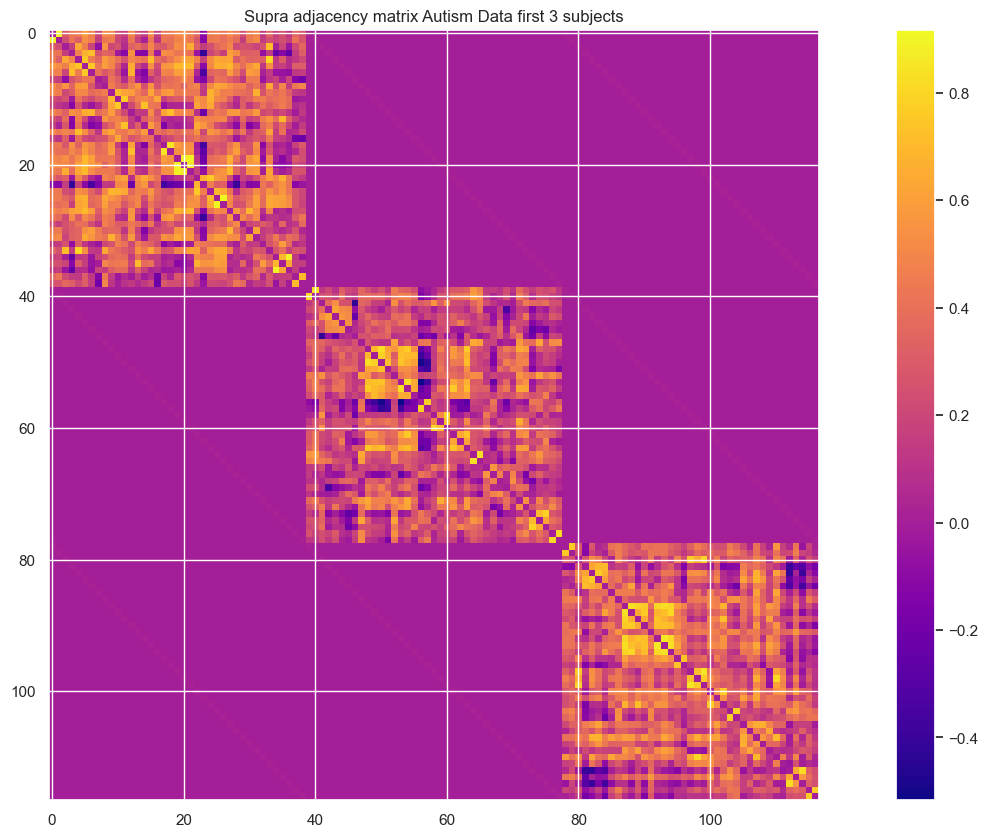

In [267]:
plt.figure(figsize=(20,10))
img = plt.imshow(mx.adjacency_matrix(mg,weight='weight').todense()[0:39*3,0:39*3],
		  origin='upper',interpolation='nearest',cmap=plt.cm.plasma) #,vmin=0,vmax=1) TODO try different colormaps
plt.title('Supra adjacency matrix Autism Data first 3 subjects')

cbar = plt.colorbar(img, cmap=plt.cm.plasma)

# list of colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

plt.show()

### 2.2 Control Subjects

In [49]:
# load control correlation matrices
control_pop_correlation_matrices = np.load("control_connectivity_matrices.npy")

In [50]:
num_control_subjects = len(control_data.func_preproc)
inter_layer_edges_weight = 0.02

list_of_layers = [mx.from_numpy_array(control_pop_correlation_matrices[i, :, :]) for i in range(num_control_subjects)]

adj_block = mx.lil_matrix(np.zeros((num_ROIs*num_control_subjects,num_ROIs*num_control_subjects)))

for i in range(num_control_subjects):
	for j in range(num_control_subjects):
	   if j > i:  
	      adj_block[i*num_ROIs: (i+1)*num_ROIs, j*num_ROIs: (j+1)*num_ROIs] = np.identity(num_ROIs)

adj_block += adj_block.T

control_mg = mx.MultilayerGraph(list_of_layers=list_of_layers, inter_adjacency_matrix=adj_block)
control_mg.set_edges_weights(inter_layer_edges_weight=inter_layer_edges_weight)

In [51]:
# Save supra-adjacency matrix to file
np.save("control_supra_adjacency_matrix.npy", mx.adjacency_matrix(control_mg,weight='weight').todense())

## 3. PageRank from De Domenic et al. 2013 (for multilayer networks)

### 3.1 Autism subjects

In [1026]:
# load autism supra-adjacency matrix
num_autism_subjects = len(autism_data.func_preproc)
print(num_autism_subjects)
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas["maps"]
labels = atlas["labels"]
num_ROIs = len(labels)

#autism_supra_adjacency_matrix = np.load("autism_supra_adjacency_matrix.npy")
autism_supra_adjacency_matrix = np.load("small_autism_supra_adjacency_matrix.npy") #TESTING

30


In [1027]:
# thresholding the network 
thresh = 0.02
autism_supra_adjacency_matrix = np.where(autism_supra_adjacency_matrix<thresh, 0, autism_supra_adjacency_matrix)

In [1028]:
# Trying normalizing the supra-adjacency matrix
std_dev = np.std(autism_supra_adjacency_matrix)
autism_supra_adjacency_matrix = (autism_supra_adjacency_matrix) / std_dev

In [917]:
# checking that supra-adjacency matrix is connected for Perron-Forbenius
G = mx.from_numpy_array(autism_supra_adjacency_matrix)
print(type(G))
print(f"Is G fully connected?: {mx.is_connected(G)}")

<class 'networkx.classes.graph.Graph'>
Is G fully connected?: True


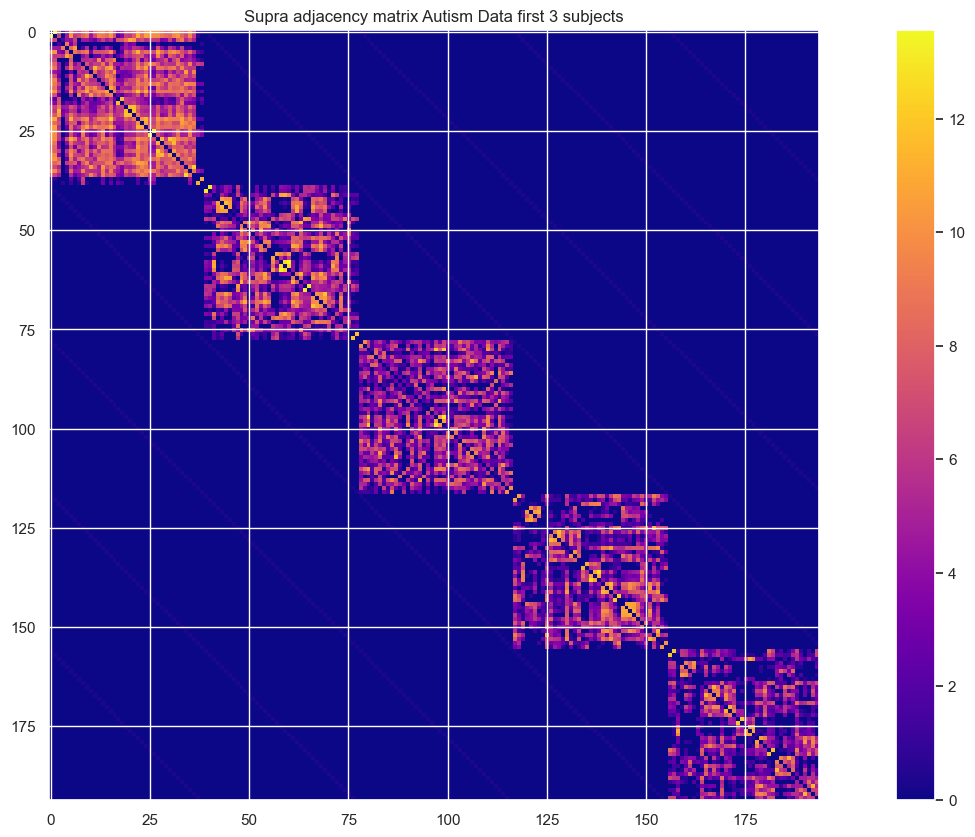

In [918]:
plt.figure(figsize=(20,10))
img = plt.imshow(autism_supra_adjacency_matrix[39*25:-1,39*25:-1],
		  origin='upper',interpolation='nearest',cmap=plt.cm.plasma) #,vmin=0,vmax=1) TODO try different colormaps
plt.title('Supra adjacency matrix Autism Data first 3 subjects')

cbar = plt.colorbar(img, cmap=plt.cm.plasma)

# list of colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

plt.show()

[221.22569575 202.73564952 189.2257056  ... 155.88651658 127.02359302
 136.94330845]


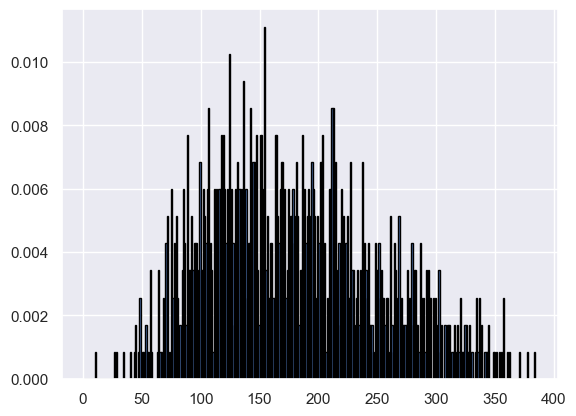

In [919]:
# computing the strength of each node
autism_strength = np.sum(autism_supra_adjacency_matrix, axis=1)
print(autism_strength)
degree_counts, bins, patches = plt.hist(autism_strength, bins=range(1, int(max(autism_strength) + 2)), edgecolor='black', density=True)

#### 3.1.1 Degree / Strength Centrality 

In [1029]:
autism_strength = autism_strength.reshape(num_autism_subjects, num_ROIs)
strength_centralities = np.sum(autism_strength, axis=0)

ValueError: cannot reshape array of size 1131 into shape (30,39)

In [921]:
# give the ordering of the nodes by degree centrality
sorted_deg_centrality = np.argsort(strength_centralities)[::-1]
print(sorted_deg_centrality)
for i in range(10):
   print(labels[sorted_deg_centrality[i]])

[32  9 13 15 22 27 24  8 33 25 21  2 31 23 26 20 30 28  5 10  4 14 35 19
 11 36 29 16 34 12  0  6  1 37 38  3 18 17  7]
Cereb
R DLPFC
Basal
L DLPFC
D ACC
L TPJ
R A Ins
Motor
Dors PCC
L STS


#### 3.1.2 Page Rank Centrality

In [1030]:
# aggregating the autism subjects
autism_pop_correlation_matrices = np.load("small_autism_connectivity_matrices.npy")
print(autism_pop_correlation_matrices.shape)
aggregate_autism_matrix = np.mean(autism_pop_correlation_matrices, axis=0)
print(aggregate_autism_matrix.shape)

(30, 39, 39)
(39, 39)


In [1031]:
#H = mx.from_numpy_array(aggregate_autism_matrix)
#pagerank_scores = mx.pagerank(H, max_iter=100000, tol=1e-02, alpha=0.85, personalization=None, nstart=None, weight='weight', dangling=None)
#print(pagerank_scores)
#print(len(pagerank_scores))

from networkx.exception import PowerIterationFailedConvergence

graph_list = [mx.from_numpy_array(autism_pop_correlation_matrices[i]) for i in range(num_autism_subjects)]
pagerank_scores = np.zeros((num_autism_subjects, num_ROIs))
print(pagerank_scores.shape)

not_converged = []
for i in tqdm(range(num_autism_subjects)): # TODO find and alternative e.g., eliminate the last subject from multiplex netowrk as well
   try:
      #print(i)
      #print(f"Is G fully connected?: {mx.is_connected(graph_list[i])}")
      pagerank_scores[i, :] = np.array(list(mx.pagerank(graph_list[i], max_iter=1000000, tol=1e-01, alpha=0.85, personalization=None, nstart=None, weight='weight', dangling=None).values()))
   except PowerIterationFailedConvergence:
      pagerank_scores[i, :] = None
      not_converged.append(i)

print(pagerank_scores.shape)

# remove not converged subjects
print(f"Subjects for which Page Rank did not converge: {not_converged}")
pagerank_scores = np.delete(pagerank_scores, not_converged, axis=0)

# mean of each node across subjects
mean_pagerank_scores = np.mean(pagerank_scores, axis=0)

# give the ordering of the nodes by page_rank_centralit
sorted_pagerank_scores = np.argsort(mean_pagerank_scores)[::-1]
for i in range(10):
   print(labels[sorted_pagerank_scores[i]])

# normalizing pagerank scores
print(pagerank_scores.shape)
pagerank_scores = pagerank_scores / np.linalg.norm(pagerank_scores)
print(pagerank_scores.shape)
# saving pagerank scores to file
np.save("aggregated_autism_pagerank_scores.npy", pagerank_scores)

(30, 39)


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/abelrassat/opt/anaconda3/envs/cn_final_proj/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/abelrassat/opt/anaconda3/envs/cn_final_proj/lib/python3.11/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:496: RuntimeWarning: invalid value encountered in subtract
  err = np.absolute(x - xlast).sum()


(30, 39)
Subjects for which Page Rank did not converge: [29]
Cereb
D ACC
Basal
L STS
R DLPFC
R Front pol
R A Ins
R STS
L Par
L TPJ
(29, 39)
(29, 39)


{'whiskers': [<matplotlib.lines.Line2D at 0x16c8988d0>,
 'caps': [<matplotlib.lines.Line2D at 0x16c899cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x16c898150>,
 'medians': [<matplotlib.lines.Line2D at 0x16c89aa50>,
 'fliers': [<matplotlib.lines.Line2D at 0x16c89b390>,
 'means': []}

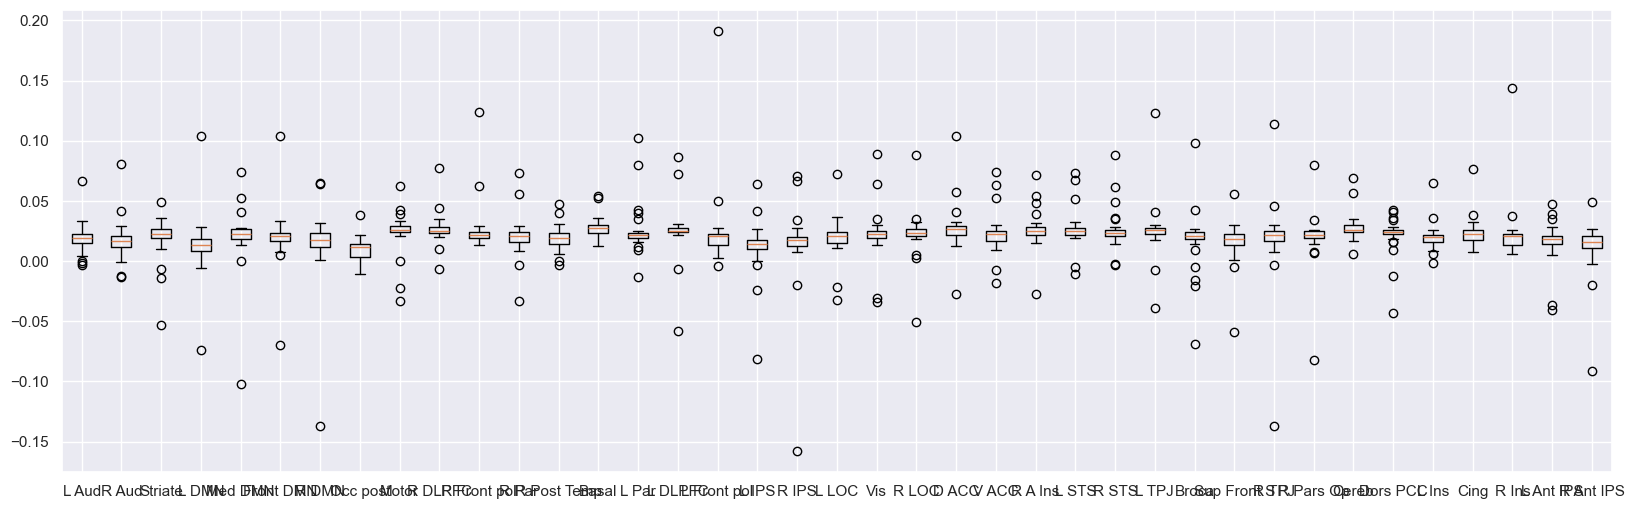

In [1032]:
plt.figure(figsize=(20, 6))
plt.boxplot(pagerank_scores, labels=labels)

In [1033]:
# remove not converged subjects from multiplex network
row_and_cols_to_remove = [np.arange(i*num_ROIs, (i+1)*num_ROIs) for i in not_converged]
row_and_cols_to_remove = np.concatenate(row_and_cols_to_remove)
autism_supra_adjacency_matrix = np.delete(autism_supra_adjacency_matrix, row_and_cols_to_remove, axis=0)
autism_supra_adjacency_matrix = np.delete(autism_supra_adjacency_matrix, row_and_cols_to_remove, axis=1)

num_autism_subjects = num_autism_subjects - len(not_converged)

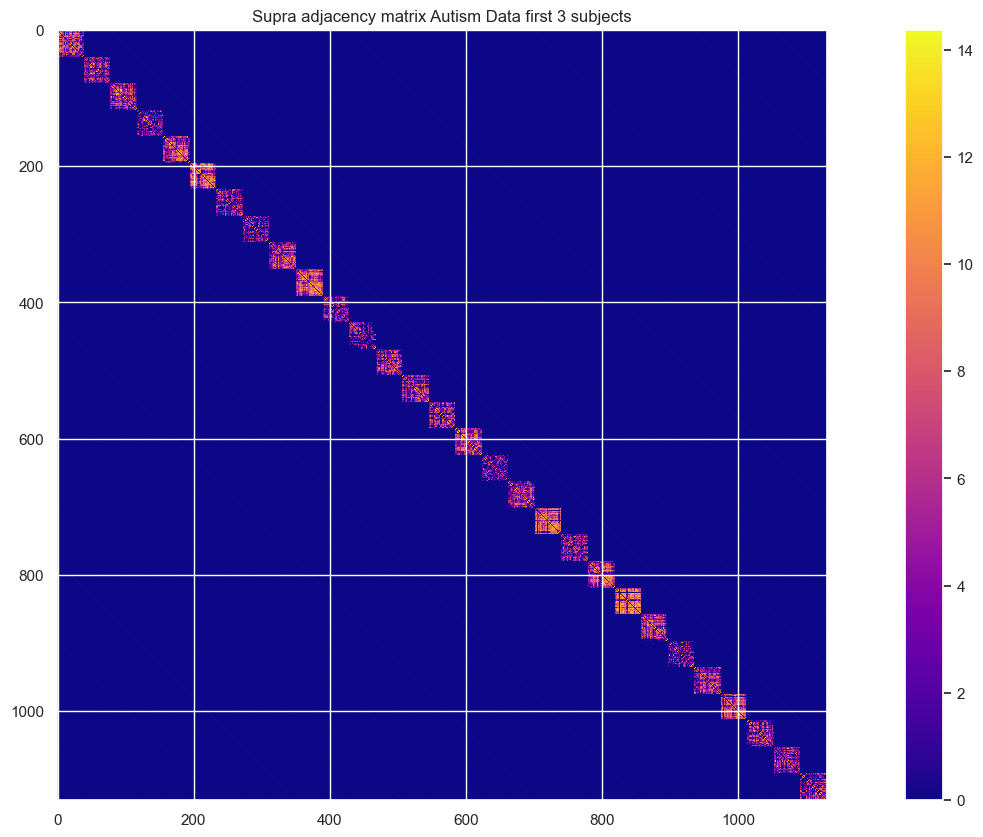

In [1034]:
plt.figure(figsize=(20,10))
img = plt.imshow(autism_supra_adjacency_matrix,
		  origin='upper',interpolation='nearest',cmap=plt.cm.plasma) #,vmin=0,vmax=1) TODO try different colormaps
plt.title('Supra adjacency matrix Autism Data first 3 subjects')

cbar = plt.colorbar(img, cmap=plt.cm.plasma)

# list of colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

plt.show()

In [991]:
# checking that supra-adjacency matrix is connected for Perron-Forbenius
G = mx.from_numpy_array(autism_supra_adjacency_matrix)

pagerank_scores = mx.pagerank(G, max_iter=100000, tol=1e-02, alpha=0.85, personalization=None, nstart=None, weight='weight', dangling=None)
print(pagerank_scores)
print(len(pagerank_scores))

pagerank_scores = np.array(list(pagerank_scores.values()))

print(pagerank_scores[:10])
pagerank_scores_reshaped = np.mean(pagerank_scores.reshape(num_autism_subjects, num_ROIs), axis=0)

# give the ordering of the nodes by page_rank_centralit
pagerank_sorted_centrality = np.argsort(pagerank_scores_reshaped)[::-1]
for i in range(10):
   print(labels[pagerank_sorted_centrality[i]])

# normalizing pagerank scores
page_rank_score = pagerank_scores_reshaped  / np.linalg.norm(pagerank_scores_reshaped )
# saving pagerank scores to file
np.save("multiplex_non_tens_autism_pagerank_scores.npy", pagerank_scores)

{0: 0.0009333269316539813, 1: 0.0008688289623704384, 2: 0.0008061785754029772, 3: 0.0007399231862180311, 4: 0.0010760046148882805, 5: 0.0010914051699358665, 6: 0.0008120025529261796, 7: 0.0006641337515646969, 8: 0.0010461233347724946, 9: 0.0010877209541000994, 10: 0.0009653189985795596, 11: 0.0007692874007274078, 12: 0.0009559241361103648, 13: 0.0007998629858487215, 14: 0.0006652448252218543, 15: 0.0010028123839367004, 16: 0.0007016513320375725, 17: 0.000819636901990036, 18: 0.0008485100068649177, 19: 0.0009328263813395644, 20: 0.0009082656959191837, 21: 0.0009638535175485717, 22: 0.000914744520806088, 23: 0.0006050686646440162, 24: 0.0010982227339258065, 25: 0.0011545098623879772, 26: 0.0011032716893020266, 27: 0.0009753623796189419, 28: 0.0007632209254380261, 29: 0.0007627689030666931, 30: 0.0008061002011385051, 31: 0.0010159616639356267, 32: 0.0006555817951222784, 33: 0.0009907902524818697, 34: 0.0007131257630604983, 35: 0.0008429146892027601, 36: 0.0006417841331746744, 37: 0.000594

In [1035]:
# computing the strength of each node
autism_strength = np.sum(autism_supra_adjacency_matrix, axis=1)

# diagonal matrix of node strength
autism_strength_matrix = np.diag(autism_strength)

# computing the inverse of the strength matrix
autism_strength_matrix_inv = np.linalg.inv(autism_strength_matrix)

# set all negative values to 0
autism_strength_matrix_inv = np.where(autism_strength_matrix_inv<0, 0, autism_strength_matrix_inv)

# equivalent as a tensor contraction between the supra-adjacency matrix and the inverse of the strength matrix
autism_transition_tensor = np.dot(autism_strength_matrix_inv, autism_supra_adjacency_matrix)

# computing the eigenvalues random walk transition tensor (flattened)
r = 0.85 # as in the orginial PageRank paper TODO tune hyperparameter
autism_RW_transition_tensor = r * autism_transition_tensor + (1-r)/autism_transition_tensor.shape[0]

In [1036]:
# computing the eigenvalues and eigenvectors of the random walk transition tensor
autism_eigvals, autism_eigvecs = np.linalg.eigh(autism_RW_transition_tensor)

39
(39,)


<BarContainer object of 39 artists>

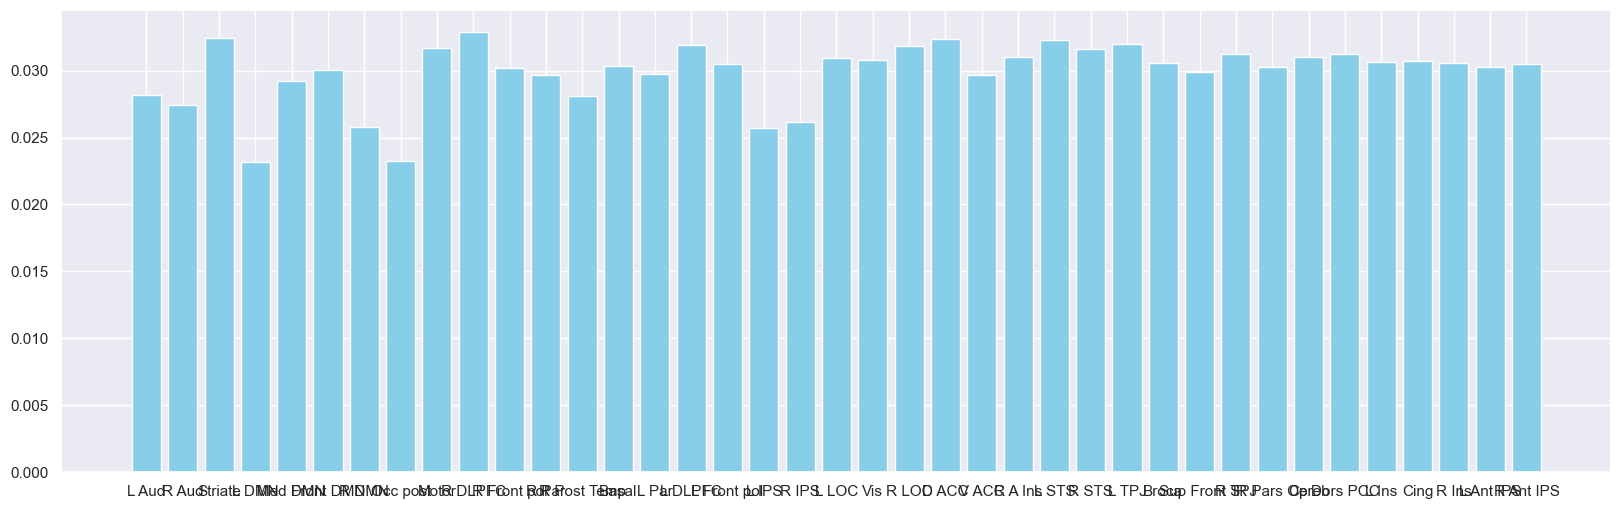

In [1037]:
print(len(labels))
plt.figure(figsize=(20, 6))
print(page_rank_centrality.shape)
plt.bar(labels, page_rank_centrality, color='skyblue')


In [1038]:
print(autism_eigvals[:10], autism_eigvals[-1])
leading_supra_eigenv = autism_eigvecs[:, -1]
if np.all(leading_supra_eigenv < 0): # TODO or can take the absolute value
   leading_supra_eigenv = -leading_supra_eigenv
print(leading_supra_eigenv)
leading_eigen_tens = leading_supra_eigenv.reshape(num_autism_subjects, num_ROIs)
page_rank_centrality = np.mean(leading_eigen_tens, axis=0)

# give the ordering of the nodes by page_rank_centrality

page_rank_sorted_centrality = np.argsort(page_rank_centrality)[::-1]
print(page_rank_sorted_centrality)
for i in range(10):
   print(labels[page_rank_sorted_centrality[i]])

# normalizing pagerank scores
pagerank_score = leading_eigen_tens / np.linalg.norm(leading_eigen_tens )
# saving pagerank scores to file
print(pagerank_score)
np.save("multiplex_tens_autism_pagerank_scores.npy", pagerank_score)

[-0.24464821 -0.21430061 -0.20911984 -0.19333662 -0.19166664 -0.17401859
 -0.16975304 -0.16752782 -0.1656103  -0.16452602] 1.0075468046156617
[0.03791223 0.0354227  0.03315178 ... 0.02720081 0.0273093  0.02662664]
[13  9  8 15 22 24 25  2 27 32 26 33 35 21 37 36 23 38 31 28 34 10 20 30
 14 29  5 19 11  4 16 12  0  6 18 17  1  3  7]
Basal
R DLPFC
Motor
L DLPFC
D ACC
R A Ins
L STS
Striate
L TPJ
Cereb
[[0.03791223 0.0354227  0.03315178 ... 0.03469699 0.03555907 0.03550039]
 [0.02832344 0.03146322 0.03274758 ... 0.03135127 0.03208507 0.03059807]
 [0.02976783 0.03134719 0.03313706 ... 0.03187409 0.03511323 0.03269196]
 ...
 [0.02010642 0.01891554 0.02629349 ... 0.02887696 0.02977438 0.02932995]
 [0.03327712 0.02893049 0.03394723 ... 0.03122058 0.03119334 0.03043955]
 [0.02949884 0.02332608 0.02218269 ... 0.02720081 0.0273093  0.02662664]]


{'whiskers': [<matplotlib.lines.Line2D at 0x1665f1d50>,
 'caps': [<matplotlib.lines.Line2D at 0x1665f1d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x166594d90>,
 'medians': [<matplotlib.lines.Line2D at 0x1665f2d90>,
 'fliers': [<matplotlib.lines.Line2D at 0x1665f2a50>,
 'means': []}

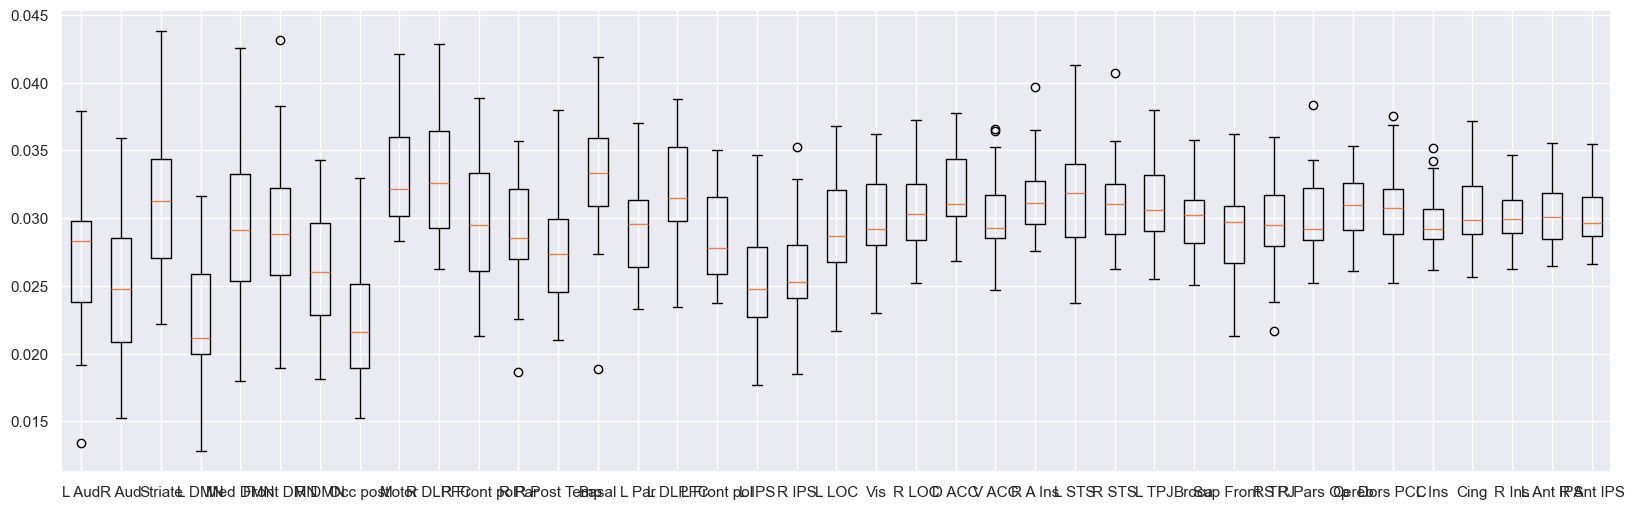

In [1003]:
plt.figure(figsize=(20, 6))
plt.boxplot(pagerank_score, labels=labels)

### 2.2 Control Subjects

In [1012]:
# load control supra-adjacency matrix
control_supra_adjacency_matrix = np.load("control_supra_adjacency_matrix.npy")
num_control_subjects = len(control_data.func_preproc)

In [1013]:
# thresholding the network
thresh = 0.02
control_supra_adjacency_matrix = np.where(control_supra_adjacency_matrix<thresh, 0, control_supra_adjacency_matrix)

In [1014]:
# Trying normalizing the supra-adjacency matrix
std_dev = np.std(control_supra_adjacency_matrix)
control_supra_adjacency_matrix = (control_supra_adjacency_matrix) / std_dev

In [968]:
# checking that supra-adjacency matrix is connected for Perron-Forbenius
G = mx.from_numpy_array(control_supra_adjacency_matrix)
print(type(G))
print(f"Is G fully connected?: {mx.is_connected(G)}")

<class 'networkx.classes.graph.Graph'>
Is G fully connected?: True


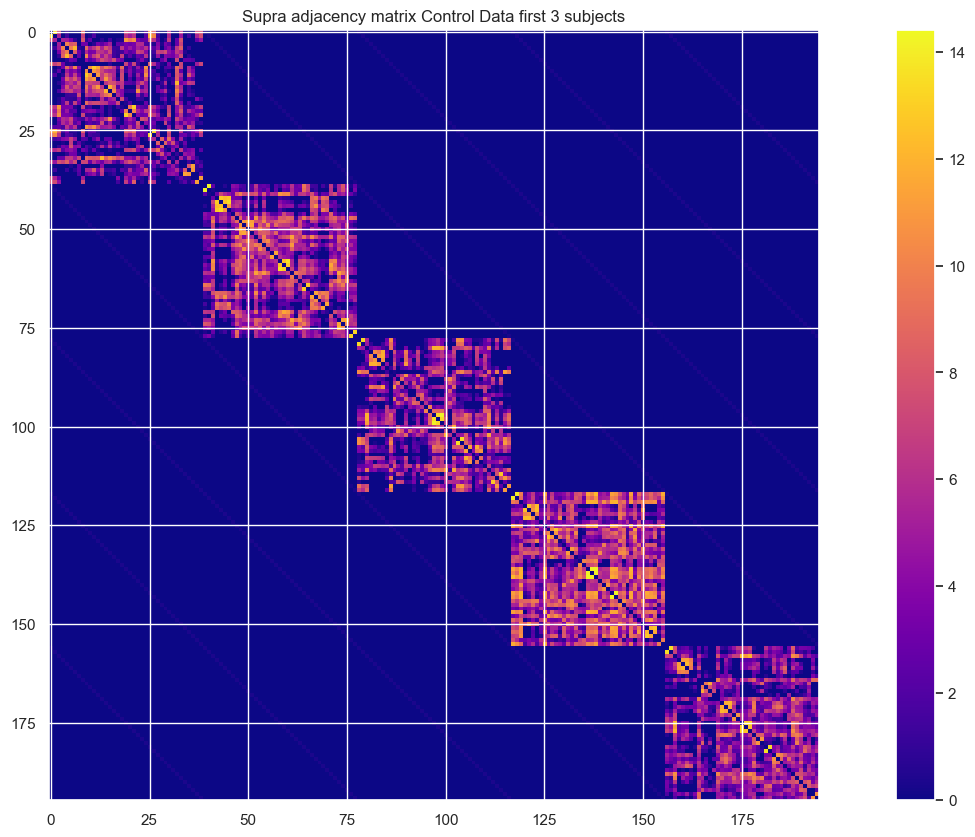

In [754]:
plt.figure(figsize=(20,10))
img = plt.imshow(control_supra_adjacency_matrix[0:39*5, 0:39*5],
		  origin='upper',interpolation='nearest',cmap=plt.cm.plasma) #,vmin=0,vmax=1) TODO try different colormaps
plt.title('Supra adjacency matrix Control Data first 3 subjects')

cbar = plt.colorbar(img, cmap=plt.cm.plasma)

# list of colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

plt.show()

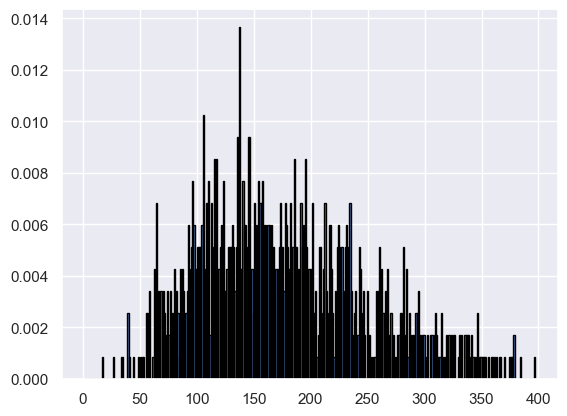

In [843]:
# computing the strength of each node
control_strength = np.sum(control_supra_adjacency_matrix, axis=1)
degree_counts, bins, patches = plt.hist(control_strength, bins=range(1, int(max(control_strength) + 2)), edgecolor='black', density=True)
# Looks somewhat like a Poisson distribution

#### 3.2.1 Degree / Strength Centrality

In [756]:
control_strength = control_strength.reshape(num_control_subjects, num_ROIs)
strength_centralities = np.sum(control_strength, axis=0)

In [757]:
# give the ordering of the nodes by degree centrality
sorted_deg_centrality = np.argsort(strength_centralities)[::-1]
print(sorted_deg_centrality)
for i in range(10):
   print(labels[sorted_deg_centrality[i]])

[27 21 32 25 22 33  9 15 30  2 19 20  8 26 24  5 13 10 31 16 28 14 11  4
 34 36 23  0 35  1 29 12 38  6 37  3  7 18 17]
L TPJ
R LOC
Cereb
L STS
D ACC
Dors PCC
R DLPFC
L DLPFC
R TPJ
Striate


#### 3.2.2 Page Rank Centrality

In [1015]:
# aggregating the control subjects
control_pop_correlation_matrices = np.load("control_connectivity_matrices.npy")
print(control_pop_correlation_matrices.shape)
aggregate_control_matrix = np.mean(control_pop_correlation_matrices, axis=0)
print(aggregate_control_matrix.shape)

(30, 39, 39)
(39, 39)


In [1016]:
#H = mx.from_numpy_array(aggregate_autism_matrix)
#pagerank_scores = mx.pagerank(H, max_iter=100000, tol=1e-02, alpha=0.85, personalization=None, nstart=None, weight='weight', dangling=None)
#print(pagerank_scores)
#print(len(pagerank_scores))

from networkx.exception import PowerIterationFailedConvergence

graph_list = [mx.from_numpy_array(control_pop_correlation_matrices[i]) for i in range(num_control_subjects)]
pagerank_scores = np.zeros((num_control_subjects, num_ROIs))
print(pagerank_scores.shape)

not_converged = []
for i in tqdm(range(num_control_subjects)): # TODO find and alternative e.g., eliminate the last subject from multiplex netowrk as well
   try:
         #print(i)
         #print(f"Is G fully connected?: {mx.is_connected(graph_list[i])}")
         pagerank_scores[i, :] = np.array(list(mx.pagerank(graph_list[i], max_iter=1000000, tol=1e-01, alpha=0.85, personalization=None, nstart=None, weight='weight', dangling=None).values()))
   except PowerIterationFailedConvergence:
         pagerank_scores[i, :] = None
         not_converged.append(i)

print(pagerank_scores.shape)

# remove not converged subjects
print(f"Subjects for which Page Rank did not converge: {not_converged}")
pagerank_scores = np.delete(pagerank_scores, not_converged, axis=0)

# mean of each node across subjects
mean_pagerank_scores = np.mean(pagerank_scores, axis=0)

# give the ordering of the nodes by page_rank_centralit
sorted_pagerank_scores = np.argsort(mean_pagerank_scores)[::-1]
for i in range(10):
   print(labels[sorted_pagerank_scores[i]])

# normalizing pagerank scores
print(pagerank_scores.shape)
pagerank_scores = pagerank_scores / np.linalg.norm(pagerank_scores)
print(pagerank_scores.shape)
# saving pagerank scores to file
np.save("aggregated_control_pagerank_scores.npy", pagerank_scores)

(30, 39)


  0%|          | 0/30 [00:00<?, ?it/s]

(30, 39)
Subjects for which Page Rank did not converge: [8, 29]
R DLPFC
Vis
R LOC
Cereb
Striate
Dors PCC
Motor
L TPJ
Basal
R A Ins
(28, 39)
(28, 39)


In [1017]:
# remove not converged subjects from multiplex network
row_and_cols_to_remove = [np.arange(i*num_ROIs, (i+1)*num_ROIs) for i in not_converged]
row_and_cols_to_remove = np.concatenate(row_and_cols_to_remove)
control_supra_adjacency_matrix = np.delete(control_supra_adjacency_matrix, row_and_cols_to_remove, axis=0)
control_supra_adjacency_matrix = np.delete(control_supra_adjacency_matrix, row_and_cols_to_remove, axis=1)

num_control_subjects -= len(not_converged)

(1170, 1170)


In [ ]:
pagerank_scores = mx.pagerank(G, max_iter=100000, tol=1e-02, alpha=0.85, personalization=None, nstart=None, weight='weight', dangling=None)
print(pagerank_scores)
print(len(pagerank_scores))

pagerank_scores = np.array(list(pagerank_scores.values()))

print(pagerank_scores[:10])
pagerank_scores_reshaped = np.mean(pagerank_scores.reshape(num_control_subjects, num_ROIs), axis=0)

# give the ordering of the nodes by page_rank_centralit
pagerank_sorted_centrality = np.argsort(pagerank_scores_reshaped)[::-1]
for i in range(10):
   print(labels[pagerank_sorted_centrality[i]])

# normalizing pagerank scores
page_rank_score = pagerank_scores_reshaped  / np.linalg.norm(pagerank_scores_reshaped )
# saving pagerank scores to file
np.save("multiplex_non_tens_control_pagerank_scores.npy", pagerank_score)

In [1019]:
# computing the strength of each node
control_strength = np.sum(control_supra_adjacency_matrix, axis=1)
print(np.all(control_strength >= 0))

# diagonal matrix of node strength
control_strength_matrix = np.diag(control_strength)

# computing the inverse of the strength matrix
control_strength_matrix_inv = np.linalg.inv(control_strength_matrix)

control_strength_matrix_inv = np.where(control_strength_matrix_inv<0, 0, control_strength_matrix_inv)

# computing the inverse of the strength matrix times the supra-adjacency matrix
# equivalent as a tensor contraction between the supra-adjacency matrix and the inverse of the strength matrix
control_transition_tensor = np.dot(control_strength_matrix_inv, control_supra_adjacency_matrix)

# computing the eigenvalues random walk transition tensor (flattened)
r = 0.85 # as in the orginial PageRank paper TODO tune hyperparameter
control_RW_transition_tensor = r * control_transition_tensor + (1-r)/control_transition_tensor.shape[0]
print(np.all(control_RW_transition_tensor>=0))

True
True


In [1020]:
# computing the eigenvalues and eigenvectors of the random walk transition tensor
control_eigvals, control_eigvecs = np.linalg.eigh(control_RW_transition_tensor)

In [1021]:
# check that contol_RW_transition_tensor has positive elements 
print(np.all(control_RW_transition_tensor >= 0))

True


In [1022]:
print(control_eigvals[:10], control_eigvals[-1])

[-0.29888202 -0.26165834 -0.22720163 -0.21995377 -0.20145709 -0.18141595
 -0.17735884 -0.17579575 -0.17447377 -0.17354971] 1.0090296113696093


In [1023]:
leading_supra_eigenv = control_eigvecs[:, -1]
if np.all(leading_supra_eigenv < 0): # TODO or can take the absolute value
   leading_supra_eigenv = -leading_supra_eigenv
print(np.all(leading_supra_eigenv >= 0))
print(leading_supra_eigenv)
leading_eigen_tens = leading_supra_eigenv.reshape(num_control_subjects, num_ROIs)
page_rank_centrality = np.mean(leading_eigen_tens, axis=0)

# give the ordering of the nodes by page_rank_centrality
page_rank_sorted_centrality = np.argsort(page_rank_centrality)[::-1]
for i in range(10):
   print(labels[page_rank_sorted_centrality[i]])

# normalizing pagerank scores
pagerank_score = leading_eigen_tens / np.linalg.norm(leading_eigen_tens)
print(pagerank_score)
print(pagerank_score.shape)
# saving pagerank scores to file
np.save("multiplex_tens_control_pagerank_scores.npy", pagerank_score)

True
[0.02704098 0.02672442 0.03035058 ... 0.031283   0.02991107 0.0302589 ]
R DLPFC
Striate
D ACC
L STS
L TPJ
L DLPFC
R LOC
Motor
R STS
Dors PCC
[[0.02704098 0.02672442 0.03035058 ... 0.03020442 0.02765784 0.02889561]
 [0.02378757 0.02202697 0.03808137 ... 0.03372874 0.03475377 0.03379917]
 [0.0242579  0.02163085 0.03225311 ... 0.02762799 0.03025118 0.0302852 ]
 ...
 [0.03547105 0.03013635 0.0398421  ... 0.03292663 0.03328548 0.03301878]
 [0.01962468 0.01732635 0.02402765 ... 0.02783113 0.02834435 0.02825319]
 [0.02518046 0.02531664 0.03586713 ... 0.031283   0.02991107 0.0302589 ]]
(28, 39)


### Trying to build a supra-adjacency matrix with 2 aspects

In [27]:
num_subjects = len(data.func_preproc)
inter_layer_edges_weight = 0.3
list_supra_adjacency_matrices_1_aspect = []

for time_segment in range(num_time_bins):

    list_of_layers = [mx.from_numpy_array(pop_correlation_matrices[i, time_segment, :, :]) for i in range(len(data.func_preproc))]

    adj_block = mx.lil_matrix(np.zeros((num_ROIs*num_subjects,num_ROIs*num_subjects)))

    for i in range(num_subjects):
        for j in range(num_subjects):
          if j > i:  
            adj_block[i*num_ROIs: (i+1)*num_ROIs, j*num_ROIs: (j+1)*num_ROIs] = np.identity(num_ROIs)

    adj_block += adj_block.T

    mg = mx.MultilayerGraph(list_of_layers=list_of_layers, inter_adjacency_matrix=adj_block)
    mg.set_edges_weights(inter_layer_edges_weight=inter_layer_edges_weight)
    #list_supra_adjacency_matrices_1_aspect.append(mx.adjacency_matrix(mg,weight='weight').todense())
    list_supra_adjacency_matrices_1_aspect.append(mg)

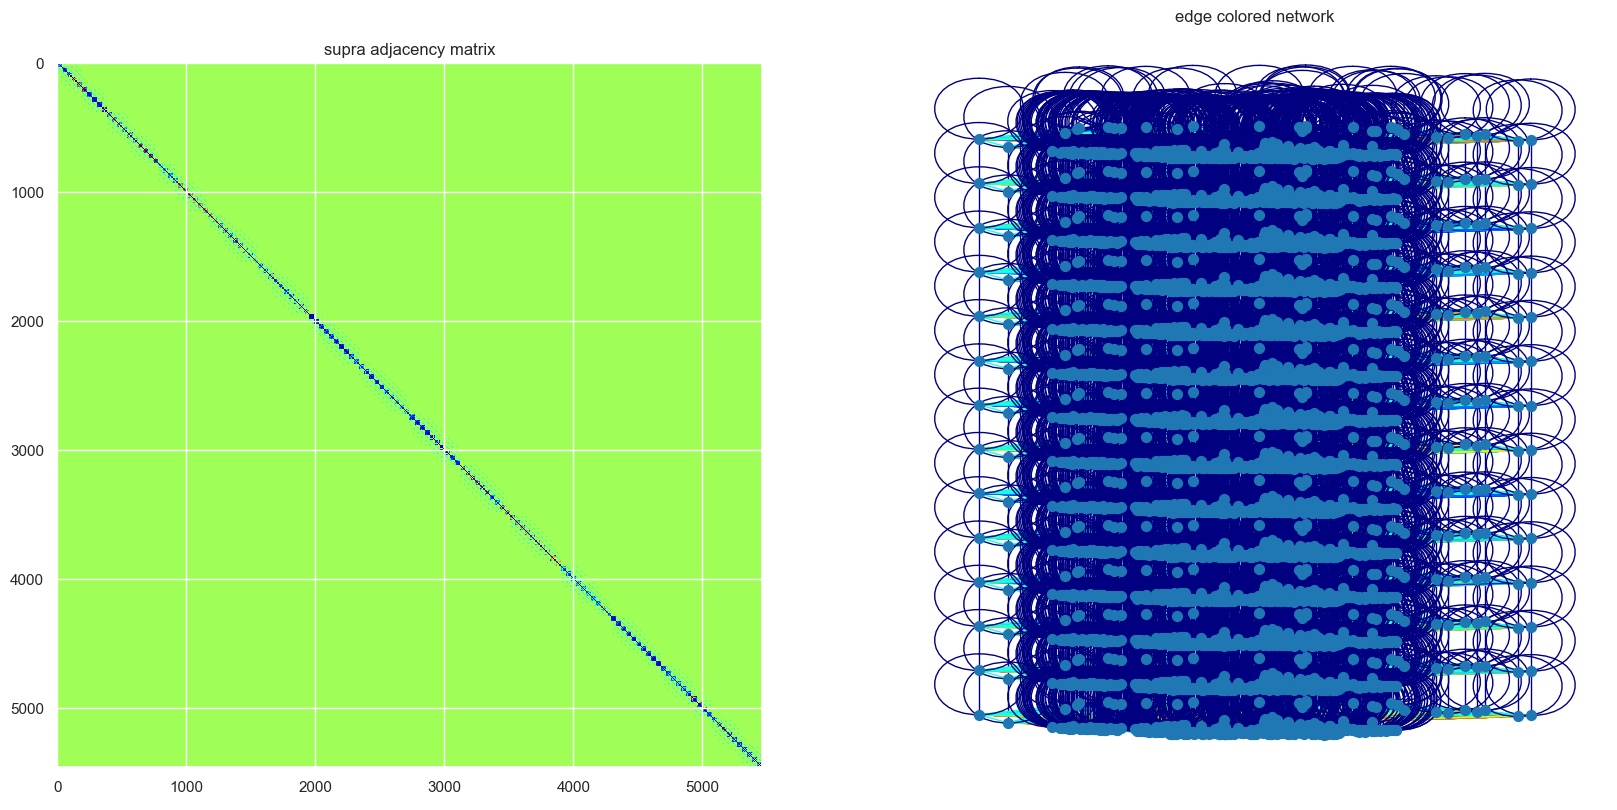

In [34]:
num_subjects = len(data.func_preproc)
inter_layer_edges_weight_ordinate = 1

adj_block_ordinate = mx.lil_matrix(np.zeros((num_ROIs*num_subjects*num_time_bins, num_ROIs*num_subjects*num_time_bins)))

for i in range(num_time_bins-1):
	adj_block_ordinate[i*num_ROIs*num_subjects: (i+1)*num_ROIs*num_subjects, (i+1)*num_ROIs*num_subjects: (i+2)*num_ROIs*num_subjects] = np.identity(num_ROIs*num_subjects)

adj_block_ordinate += adj_block_ordinate.T

supra_adjacency_matrix_2_aspects = mx.MultilayerGraph(list_of_layers=list_supra_adjacency_matrices_1_aspect, inter_adjacency_matrix=adj_block_ordinate)
supra_adjacency_matrix_2_aspects.set_edges_weights(inter_layer_edges_weight=inter_layer_edges_weight_ordinate)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(supra_adjacency_matrix_2_aspects,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(supra_adjacency_matrix_2_aspects,mx.fruchterman_reingold_layout(list_supra_adjacency_matrices_1_aspect[0]),
					  layer_vertical_shift=0.2,
					  layer_horizontal_shift=0.0,
					  proj_angle=47)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
				 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
				 edge_cmap=plt.cm.jet_r)
plt.show()

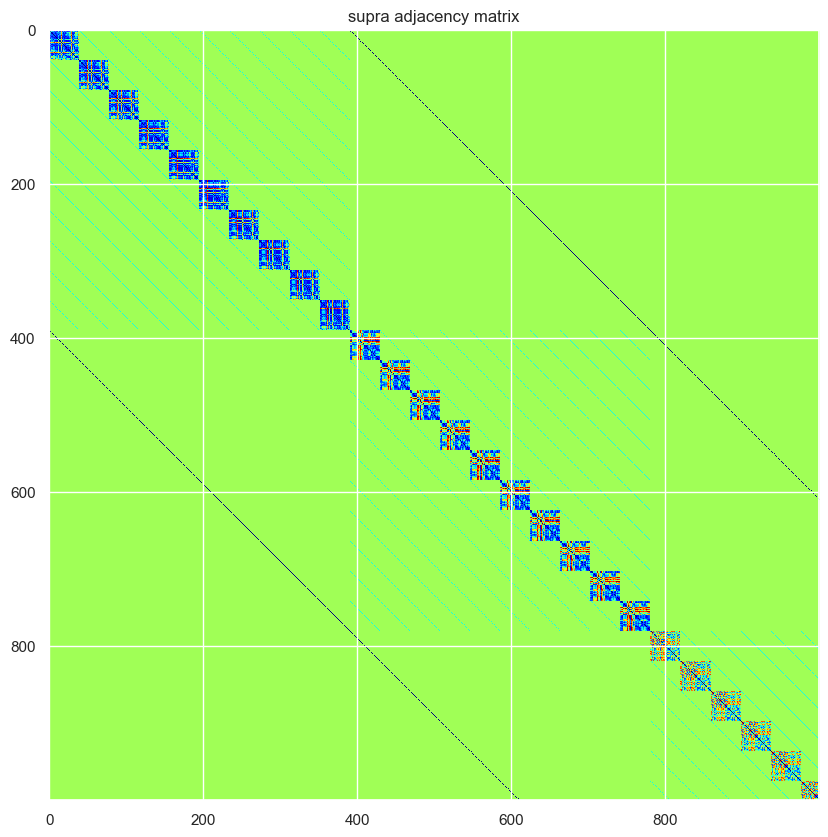

In [42]:
matrix = mx.adjacency_matrix(supra_adjacency_matrix_2_aspects,weight='weight').todense()[0:1000, 0:1000]

fig = plt.figure(figsize=(20,10))

plt.imshow(matrix, origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
plt.title('supra adjacency matrix')

plt.show()

In [75]:
print(correlation_matrix_2.shape)

()


(2, 3, 50004, 3, 50004, 'PITT', 'Pitt_0050004', 1, 1, 19.09, 1, 'R', nan, 113., 108., 117., 'WASI', 'WASI', 'WASI', 19., 12., 5., 3., 1., 4., 18., 6., 12., 2., 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, '0', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 2, nan, nan, 7.69814438, 1.22621772, 9.72575046, 3.88168429, 0.17418572, 9.32346277, 0.57895965, 63.31794342, 1.86610353, 1.18060539, 0.00826225, 0.01425995, 0.12774463, 29., 14.4278607, 0.04674525, 'OK', nan, 'OK', nan, 'OK', nan, 'OK', nan, 'OK', nan, 1)


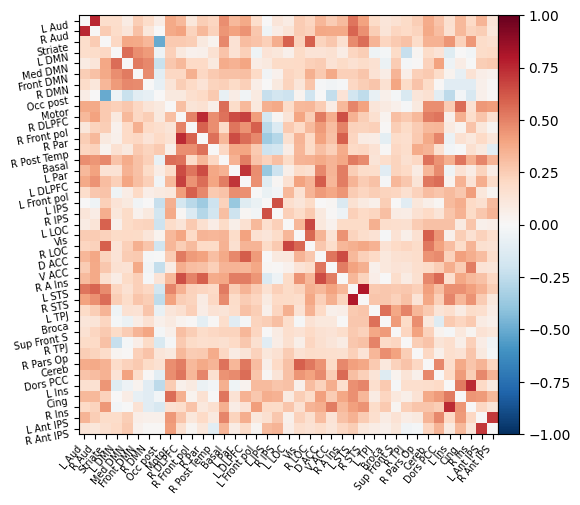

In [79]:
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(
    correlation_matrix, labels=labels, colorbar=True, vmax=1, vmin=-1
)
print(data.phenotypic[1])

# Mask out the major diagonal
# np.fill_diagonal(correlation_matrix_2, 0)
# plotting.plot_matrix(
#     correlation_matrix_2, labels=labels, colorbar=True, vmax=0.8, vmin=-0.8
# )

---

---

## Edge colored network (no inter-connected layers)

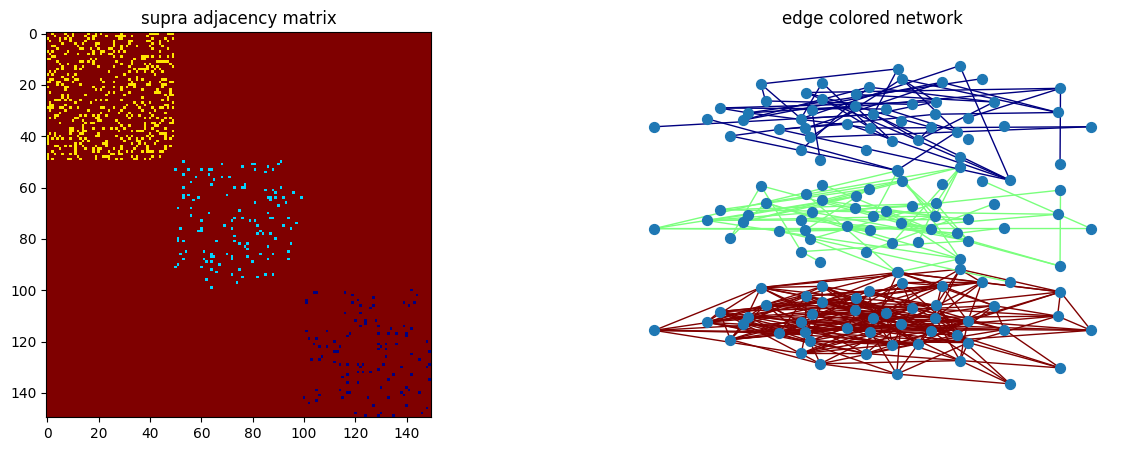

In [133]:
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3])

mg.set_intra_edges_weights(layer=0,weight=1)
mg.set_intra_edges_weights(layer=1,weight=2)
mg.set_intra_edges_weights(layer=2,weight=3)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
					  layer_vertical_shift=0.2,
					  layer_horizontal_shift=0.0,
					  proj_angle=47)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
				 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
				 edge_cmap=plt.cm.jet_r)
plt.show()

## Regular Interconnected multiplex

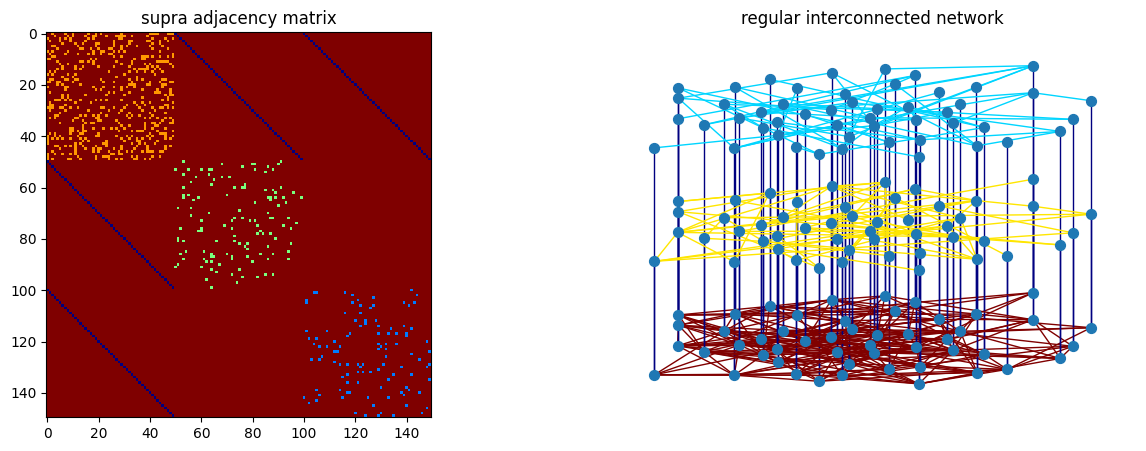

In [134]:
adj_block = mx.lil_matrix(np.zeros((N*3,N*3)))

adj_block[0:  N,  N:2*N] = np.identity(N)    # L_12
adj_block[0:  N,2*N:3*N] = np.identity(N)    # L_13
#adj_block[N:2*N,2*N:3*N] = np.identity(N)    # L_23
adj_block += adj_block.T

# Create instance of the MultilayerGraph class
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3], 
						inter_adjacency_matrix=adj_block)

mg.set_edges_weights(inter_layer_edges_weight=4)

mg.set_intra_edges_weights(layer=0,weight=1)
mg.set_intra_edges_weights(layer=1,weight=2)
mg.set_intra_edges_weights(layer=2,weight=3)

# Plot the adjacency matrix and the matrix networks
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('regular interconnected network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(mg.get_layer(0)),
					  layer_vertical_shift=1.4,
					  layer_horizontal_shift=0.0,
					  proj_angle=7)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
				 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
				 edge_cmap=plt.cm.jet_r)
plt.show()

---
---
# In Case of a time separation analysis 

In [ ]:
from nilearn.plotting import plot_carpet
from nilearn import masking

mask_img = masking.compute_epi_mask(autism_data.func_preproc[0])

display = plot_carpet(
    autism_data.func_preproc[0],
    mask_img,
    t_r=1.5,
    standardize="zscore_sample",
)

# Relation between t_r and time_series length (196)
print(196*1.5)

### Checking that all recorings are of the same duration for the first 10 subjects

In [ ]:
dict_tr = {}
dict_num_samples = {}

for i in range(len(autism_data.func_preproc)):
   subj_1 = autism_data.func_preproc[i]

   # loading the NIfTI file 
   img = nib.load(subj_1)

   #if img.shape != (61, 73, 61, 196):
   
   if img.header['pixdim'][4] in dict_tr:
      dict_tr[img.header['pixdim'][4]].append(i)
      dict_num_samples[img.header['pixdim'][4]].add(img.shape[3])
      #print(i)
   else:
      dict_tr[img.header['pixdim'][4]] = [i]
      dict_num_samples[img.header['pixdim'][4]] = set()

   #print(img.header['pixdim'][4]) # t_r 

In [ ]:
print(dict_tr)
tr_lengnths = [len(dict_tr[i]) for i in dict_tr.keys()]
print(tr_lengnths)

print(dict_num_samples)

### Removing Subjects who's recordings are shorter than 150 

### Time based composition (in 14 equal, non-overlapping intervals) for one subject as done in De Domenico 2017

In [ ]:
print(f"Time series shape: {time_series.shape}")
num_time_bins = 14  # must be a multiple of 196
correlation_matrices_time_bin = [correlation_measure.fit_transform([time_series[i*num_time_bins:i*num_time_bins+num_time_bins, :]])[0] for i in range(int(196/num_time_bins))]

#### Checking on the correlation matrices from time binning

In [ ]:
for i in range(len(autism_data.func_preproc)):
    np.fill_diagonal(correlation_matrices_time_bin[i], 0)
    plotting.plot_matrix(
        correlation_matrices_time_bin[i], labels=labels, colorbar=True, vmax=1, vmin=-1
        )

### Creating a list of Graphs for each time series

In [ ]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]
num_ROIs = len(labels)
num_time_bins = 14  # must be a multiple of 196

# Create a masker to extract time series
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize="zscore_sample")
correlation_measure = ConnectivityMeasure(kind="correlation")

pop_correlation_matrices = np.zeros((len(autism_data.func_preproc), num_time_bins, num_ROIs, num_ROIs))

for i in tqdm(range(len(autism_data.func_preproc))):

    subj = autism_data.func_preproc[i]
    img = nib.load(subj_1)
    masker.fit(img)
    time_series = masker.transform(img)
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    pop_correlation_matrices[i, :, :, :] = np.array([correlation_measure.fit_transform([time_series[i*num_time_bins:i*num_time_bins+num_time_bins, :]])[0] for i in range(int(196/num_time_bins))])

In [ ]:
print(pop_correlation_matrices.shape)

In [ ]:
import multinetx as mx

num_subjects = len(autism_data.func_preproc)
time_segment = 1
inter_layer_edges_weight = 0.3

list_of_layers = [mx.from_numpy_array(pop_correlation_matrices[i, time_segment, :, :]) for i in range(len(autism_data.func_preproc))]

adj_block = mx.lil_matrix(np.zeros((num_ROIs*num_subjects,num_ROIs*num_subjects)))


print(adj_block.shape)
print(np.identity(num_ROIs).shape)
for i in range(num_subjects):
	for j in range(num_subjects):
	   if j > i:  
	      adj_block[i*num_ROIs: (i+1)*num_ROIs, j*num_ROIs: (j+1)*num_ROIs] = np.identity(num_ROIs)

adj_block += adj_block.T

mg = mx.MultilayerGraph(list_of_layers=list_of_layers, inter_adjacency_matrix=adj_block)
mg.set_edges_weights(inter_layer_edges_weight=inter_layer_edges_weight)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(list_of_layers[0]),
					  layer_vertical_shift=0.2,
					  layer_horizontal_shift=0.0,
					  proj_angle=47)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
				 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
				 edge_cmap=plt.cm.jet_r)
plt.show()